[Reference](https://towardsdatascience.com/how-not-to-be-fooled-by-time-series-forecasting-8044f5838de3)

In [1]:
pip install scalecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scalecast.Forecaster import Forecaster
import pandas_datareader as pdr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Make up example data


In [3]:
data = pd.DataFrame(
    {
        'Date':pd.date_range(start='2013-01-01',freq='MS',periods=100)
    },
)

In [4]:
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Target'] = 1


In [5]:
for i,v in data.iterrows():
    if i > 0:
        data.loc[i,'Target'] = (
            .9 * data.loc[i-1,'Target']                 # lag1
            - .05 * np.sin(np.pi * v['Month']/(12/2))   # seasonality
            + .07 * np.cos(np.pi * v['Month']/(12/2))   # seasonality
            + .002 * v['Year']                          # trend
            + np.random.normal(scale=5)                 # resid
        )


In [6]:
data = data.set_index('Date')

In [7]:
data.head()

,Month,Year,Target
Date,,,
2013-01-01,1,2013,1.000000
2013-02-01,2,2013,10.929546
2013-03-01,3,2013,12.365201
2013-04-01,4,2013,14.847150
2013-05-01,5,2013,14.238417


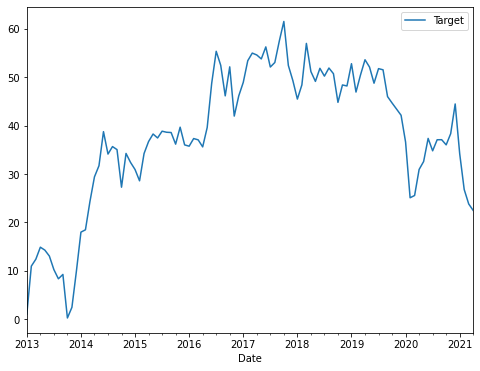

In [8]:
data.plot(y='Target',figsize=(8,6))
plt.show()

# Preprocess for Modeling


In [9]:
data['AR1'] = data['Target'].shift()
data['MonthSin'] = data['Month'].apply(lambda x: np.sin(np.pi * x/(12/2)))
data['MonthCos'] = data['Month'].apply(lambda x: np.cos(np.pi * x/(12/2)))

In [10]:
data_processed = data[['Target','AR1','MonthSin','MonthCos','Year']].dropna()
data_processed.head()

,Target,AR1,MonthSin,MonthCos,Year
Date,,,,,
2013-02-01,10.929546,1.000000,8.660254e-01,5.000000e-01,2013
2013-03-01,12.365201,10.929546,1.000000e+00,6.123234e-17,2013
2013-04-01,14.847150,12.365201,8.660254e-01,-5.000000e-01,2013
2013-05-01,14.238417,14.847150,5.000000e-01,-8.660254e-01,2013
2013-06-01,13.008605,14.238417,1.224647e-16,-1.000000e+00,2013


# Time Series Split

In [11]:
y = data_processed['Target']
X = data_processed.drop('Target',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, shuffle=False)


# Train Linear Model


In [12]:
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)

# Evaluate Results


In [13]:
mean_absolute_error(y_test,pred)

4.439382089372714

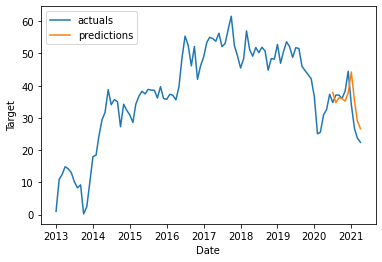

In [14]:
sns.lineplot(y='Target',x='Date',data=data.reset_index(),label='actuals')
sns.lineplot(y=pred,x=data.index[-10:],label='predictions')
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

# Redo with Scalecast


In [15]:
f = Forecaster(y=data['Target'],current_dates=data.index)
f.set_test_length(10)
f.generate_future_dates(10)
f.add_seasonal_regressors('month',sincos=True,raw=False)
f.add_seasonal_regressors('year')
f.add_ar_terms(1)
f

Forecaster(
    DateStartActuals=2013-01-01T00:00:00.000000000
    DateEndActuals=2021-04-01T00:00:00.000000000
    Freq=MS
    N_actuals=100
    ForecastLength=10
    Xvars=['monthsin', 'monthcos', 'year', 'AR1']
    Differenced=0
    TestLength=10
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

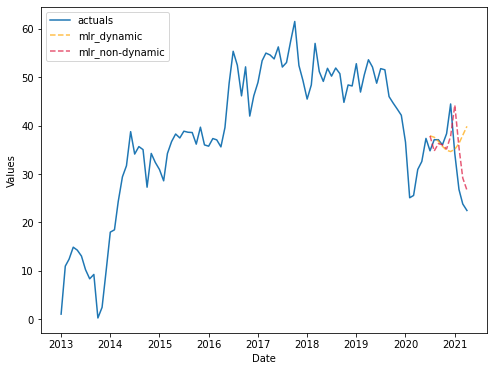

In [16]:
f.set_estimator('mlr')
f.manual_forecast(call_me='mlr_dynamic')
f.manual_forecast(call_me='mlr_non-dynamic',dynamic_testing=False)
f.plot_test_set()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

In [17]:
f.export('model_summaries')[['ModelNickname','TestSetMAE']]

,ModelNickname,TestSetMAE
0,mlr_non-dynamic,4.439382
1,mlr_dynamic,5.960332


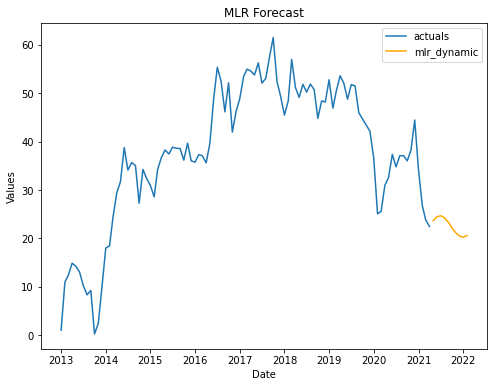

In [18]:
f.plot(models='mlr_dynamic')
plt.title('MLR Forecast')
plt.show()

# Predict the Unpredictable


In [19]:
def prepare_fcst(f):
    f.set_test_length(.3)
    f.generate_future_dates(int(len(f.y)*.3))
    f.add_seasonal_regressors('month',sincos=True,raw=False)
    f.add_seasonal_regressors('year')
    f.add_ar_terms(1)
    return f

def fcst(f):
    f.set_estimator('mlr')
    f.manual_forecast(call_me='mlr_dynamic')
    f.manual_forecast(call_me='mlr_non-dynamic',dynamic_testing=False)
    return f.plot_test_set()

def export(f):
    return f.export('model_summaries')[['ModelNickname','TestSetMAE']]

In [25]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 7.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [23]:
sp500 = pdr.get_data_yahoo('^GSPC')
btc = pdr.get_data_yahoo('BTC')
covid_affected = pd.read_csv('https://raw.githubusercontent.com/mikekeith52/scalecast-examples/main/misc/validation/fooled_by_forecasting_models/IAH-Dom.csv')

In [24]:
f_sp500 = Forecaster(y=sp500['Close'],current_dates=sp500.index)
prepare_fcst(f_sp500)

Forecaster(
    DateStartActuals=2017-06-19T00:00:00.000000000
    DateEndActuals=2022-06-17T00:00:00.000000000
    Freq=None
    N_actuals=1260
    ForecastLength=378
    Xvars=['monthsin', 'monthcos', 'year', 'AR1']
    Differenced=0
    TestLength=378
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

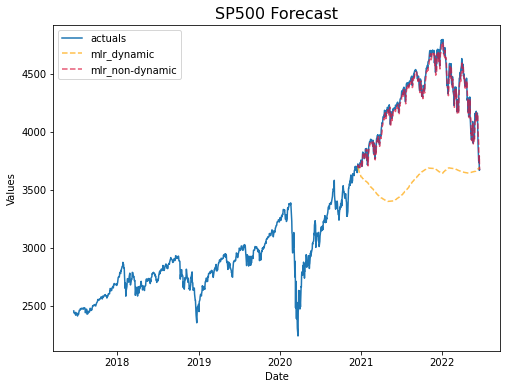

In [25]:
fcst(f_sp500)
plt.title('SP500 Forecast',size=16)
plt.show()

In [26]:
export(f_sp500)

,ModelNickname,TestSetMAE
0,mlr_non-dynamic,39.852092
1,mlr_dynamic,690.469163


In [27]:
f_btc = Forecaster(y=btc['Close'],current_dates=btc.index)
prepare_fcst(f_btc)

Forecaster(
    DateStartActuals=2020-10-01T00:00:00.000000000
    DateEndActuals=2022-06-16T00:00:00.000000000
    Freq=None
    N_actuals=431
    ForecastLength=129
    Xvars=['monthsin', 'monthcos', 'year', 'AR1']
    Differenced=0
    TestLength=129
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

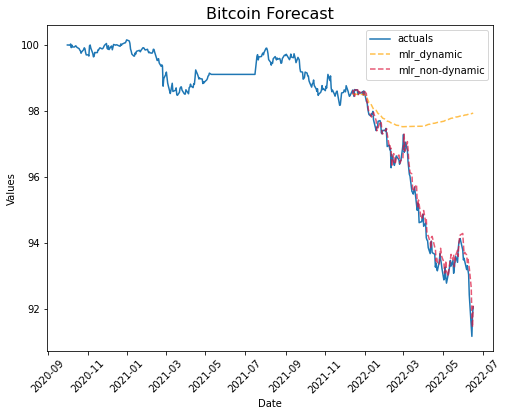

In [28]:
fcst(f_btc)
plt.xticks(rotation = 45)
plt.title('Bitcoin Forecast',size=16)
plt.show()

In [29]:
export(f_btc)

,ModelNickname,TestSetMAE
0,mlr_non-dynamic,0.205683
1,mlr_dynamic,2.312914


In [30]:
f_covid = Forecaster(y=covid_affected['PASSENGERS'],current_dates=covid_affected['Date'])
prepare_fcst(f_covid)

Forecaster(
    DateStartActuals=2001-01-01T00:00:00.000000000
    DateEndActuals=2021-09-01T00:00:00.000000000
    Freq=MS
    N_actuals=249
    ForecastLength=74
    Xvars=['monthsin', 'monthcos', 'year', 'AR1']
    Differenced=0
    TestLength=74
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

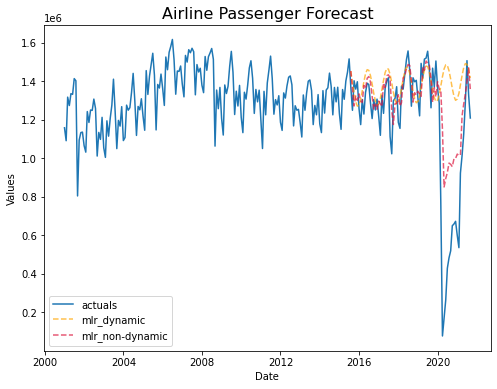

In [31]:
fcst(f_covid)
plt.title('Airline Passenger Forecast',size=16)
plt.show()

In [32]:
export(f_covid)

,ModelNickname,TestSetMAE
0,mlr_non-dynamic,159422.546480
1,mlr_dynamic,238301.755286
